# **First try to create a qutrit-based quantum autoencoder, which is basically a literal translation of the paper ‘https://arxiv.org/abs/2502.17301’ to qutrits**

This script implements a **qutrit Quantum Autoencoder (QAE)** inspired by the paper *‘https://arxiv.org/abs/2502.17301’*, applied to high-energy physics jet data. Key steps include:

- **Data loading and preprocessing:**  
  Reads jet events from JSON, computes constituent features (`pT`, `η`, `φ`, `mass`), selects top constituents, and formats the data for quantum encoding.

- **Dataset splitting:**  
  Splits processed data into training, validation, and inference sets for model development and evaluation.

- **Quantum operators and generators:**  
  Defines SU(3) Gell-Mann matrices and SO(3) spin-1 generators, constructs two-qutrit swap operations, and builds unitaries from generators for qutrit rotations.

- **Qutrit quantum autoencoder circuit:**  
  - **Encoder Layer:** Encodes jet constituent features into qutrit states via unitary rotations.  
  - **Variational Layer:** Applies parameterized TAdd gates and single-qutrit rotations for optimization.  
  - **Autoencoder Circuit:** Combines encoder and variational layers, performs controlled TSwap operations with an ancilla qutrit, and measures fidelity.  
  - **Cost Function:** Uses negative fidelity as the optimization objective.

- **Training:**  
  Optimizes variational parameters using Adam, tracks per-event and average fidelities, and prints epoch-wise performance.

- **Inference and evaluation:**  
  Computes fidelities for background and signal datasets (`H→bb`, `t→bqq`, `W→qq`), labels events, and records per-event results.

- **Visualization:**  
  - Plots **fidelity distributions** for different jet types.  
  - Computes and visualizes **ROC curves and AUC scores** using anomaly scores (`1 - fidelity`) to assess the QAE’s ability to discriminate signals from background.

Overall, the script demonstrates a full workflow for **training, evaluating, and visualizing a qutrit-based quantum autoencoder applied to particle physics data**.


In [1]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import numpy as np
from IPython.display import clear_output
import pennylane as qml
from sklearn.model_selection import train_test_split

/Users/mcarou/Documents/PhD/Proyecto/Research-Intership-Memory/python_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#  **Loading and processing jet event data**

This script defines a function `cargar_datos_json` to **load and preprocess jet event data** from a JSON file. It reads a specified number of jets and extracts the kinematic properties of each jet (`pT`, `eta`, `phi`, `mass`). For each jet, it computes the transverse momentum of its constituent particles, selects the top constituents based on highest `pT`, and calculates derived features such as `eta`, `phi`, `mass`, and energy. The processed jets and their top constituents are stored in a structured list of dictionaries, ready for further analysis or quantum circuit encoding.


### **Real CMS data**

In [ ]:
datos = []

def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calculate pT for each constituent
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Indices of the top 10 constituents by pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convert each one to the format used in the circuit
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            pt = np.sqrt(px**2 + py**2)
            eta = 0.5 * np.log((E + pz) / (E - pz + 1e-8))  # avoid division by zero
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))  # In case of negative mass, set to zero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'constituents': top_constituents
        })

    return eventos


datos = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_reducido_22500.json')

### **Simulated CMS data**

In [ ]:
def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract information from the jet
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        
        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        
        # Calculate pt, eta, phi for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        theta = np.arccos(part_pz / (p_total + 1e-8))  # Avoid division by zero
        eta = -np.log(np.tan(theta / 2 + 1e-8))
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Select the num_constituents with highest pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'constituents': top_constituents
        })

    return eventos


datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120.json', num_jets=10000, num_constituents=10)

# Splitting jet data into training, validation, and inference sets

This script converts the processed jet data into a NumPy array and **splits it into training, validation, and inference datasets**. Specifically, it selects 10,000 events for training, 2,500 for validation, and the remaining 10,000 for inference. The splits are randomized using a fixed seed for reproducibility. Finally, it prints the sizes of each subset to verify the split.


In [ ]:
datos = np.array(datos)

# Separate 10,000 for training and 12,500 remaining
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Separate 2,500 for validation and 10,000 for inference
X_val, X_inf = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

# Verify sizes
print(f"Trainning: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Inference: {len(X_inf)}")

Entrenamiento: 10000
Validación: 2500
Inferencia: 10000


---
---
---
---

### **Remembering paper**

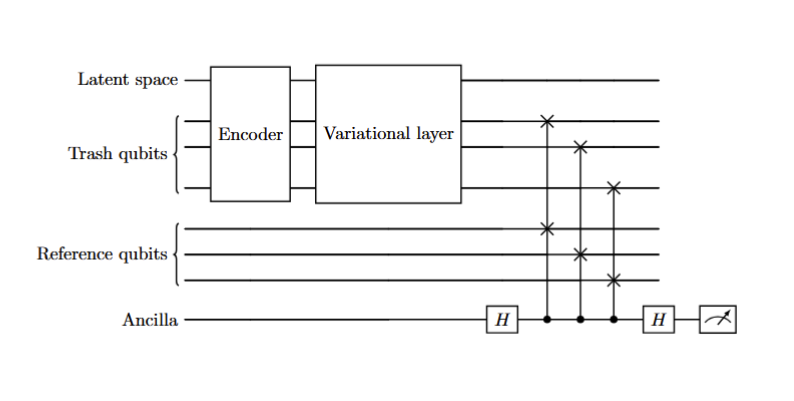

# **Quantum operators and rotation generators for qutrits**

This script defines fundamental **quantum operators and rotation generators** for qutrit systems using PennyLane, NumPy, and PyTorch. It includes:

- **Gell-Mann matrices** (`Lambda`) representing the SU(3) algebra, including the identity matrix.
- **Spin-1 rotation generators** (`Sigma`) corresponding to the SO(3) subalgebra of SU(3).
- A function `TSWAP_matrix()` that constructs the **two-qutrit swap operator**, exchanging the states of two qutrits.
- A function `unitary_from_generator(generator_matrix, theta)` that builds a **unitary matrix from a generator**, implementing rotations in qutrit space.

These components provide the mathematical framework to encode and manipulate qutrit quantum states and perform controlled rotations or gates in quantum simulations.


In [ ]:


# Gell-Mann matrices (SU(3))
Lambda = {
    1: np.array([[0, 1, 0],
                 [1, 0, 0],
                 [0, 0, 0]], dtype=complex),

    2: np.array([[0, -1j, 0],
                 [1j, 0, 0],
                 [0, 0, 0]], dtype=complex),

    3: np.array([[1, 0, 0],
                 [0, -1, 0],
                 [0, 0, 0]], dtype=complex),

    4: np.array([[0, 0, 1],
                 [0, 0, 0],
                 [1, 0, 0]], dtype=complex),

    5: np.array([[0, 0, -1j],
                 [0, 0, 0],
                 [1j, 0, 0]], dtype=complex),

    6: np.array([[0, 0, 0],
                 [0, 0, 1],
                 [0, 1, 0]], dtype=complex),

    7: np.array([[0, 0, 0],
                 [0, 0, -1j],
                 [0, 1j, 0]], dtype=complex),

    8: (1/np.sqrt(3)) * np.array([[1, 0, 0],
                                  [0, 1, 0],
                                  [0, 0, -2]], dtype=complex),
    0: torch.tensor([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]], dtype=torch.cdouble)
}

# Spin-1 rotation generators (SO(3) ⊂ SU(3))
Sigma = {
    1: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=torch.cdouble),

    2: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, -1j, 0],
        [1j, 0, -1j],
        [0, 1j, 0]
    ], dtype=torch.cdouble),

    3: torch.tensor([
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, -1]
    ], dtype=torch.cdouble)
}

def TSWAP_matrix():
    tswap = np.zeros((9, 9), dtype=complex)
    for i in range(3):
        for j in range(3):
            ket = np.zeros(9)
            bra = np.zeros(9)
            ket[3*i + j] = 1   # |i⟩|j⟩
            bra[3*j + i] = 1   # |j⟩|i⟩
            tswap += np.outer(bra, ket)
    return tswap

def unitary_from_generator(generator_matrix, theta):
    if not torch.is_tensor(theta):
        theta = torch.tensor(theta, dtype=torch.cdouble)
    i = torch.tensor(1j, dtype=torch.cdouble)
    return Lambda[0] + (torch.cos(theta) - torch.tensor(1.0)) * generator_matrix @ generator_matrix + i * torch.sin(theta) * generator_matrix


# **Qutrit quantum autoencoder circuit**

This script implements a **Quantum Autoencoder (QAE) for qutrits** using PennyLane and PyTorch. Key features include:

- **Circuit Parameters:**  
  Defines the number of particles, latent qubits, reference and trash wires, and an ancilla qutrit. The device is set to `"default.qutrit"` to work with qutrits instead of qubits.

- **Encoding Functions:**  
  `phi_circuit`, `theta_circuit`, and `mass_circuit` encode the jet constituent features (φ, η, mass) into rotation angles, normalized by the constituent and jet transverse momentum (`pt`).

- **Encoder Layer (`encode_1p1q_qutrit`):**  
  Applies **qutrit unitaries** derived from the Spin-1 rotation generators (`Sigma`) to encode each constituent’s features into the corresponding qutrit.

- **Variational Layer (`variational_layer_qutrit`):**  
  Implements a parameterized layer with **TAdd gates** (controlled addition) between particle qutrits and single-qutrit rotations (RX, RY, RZ) for optimization in the variational circuit.

- **Quantum Autoencoder Circuit (`qae_circuit_qutrit`):**  
  Combines the encoder and variational layers, applies **controlled TSwap operations** between trash and reference wires using the ancilla qutrit, and measures the probability on the ancilla to evaluate fidelity.

- **Cost Function (`cost_function_with_fidelity_qutrit`):**  
  Computes the **negative fidelity** of the ancilla state as the cost, enabling gradient-based optimization of the autoencoder.



In [ ]:
# --- Circuit parameters ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qutrit", wires=wires)  # Changed to qutrits

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

# --- Encoding functions ---
def f(w): return 1 + (2 * np.pi / (1 + torch.exp(-w)))
def phi_circuit(w, phi, phi_jet, pt, pt_jet): return f(w) * (pt / pt_jet) * (phi - phi_jet)
def theta_circuit(w, eta, eta_jet, pt, pt_jet): return f(w) * (pt / pt_jet) * (eta - eta_jet)
def mass_circuit(w, mass, mass_jet, pt, pt_jet):  return  f(w) * (pt / pt_jet) * (mass - mass_jet)

# --- Approximate encoder for qutrits ---
def encode_1p1q_qutrit(jet, w):
    pt_jet = jet['pt_jet']
    eta_jet = jet['eta_jet']
    phi_jet = jet['phi_jet']
    mass_jet = jet['mass_jet']
    constituents = jet['constituents']
        
    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        mass = mass_circuit(w, c['mass'], mass_jet, c['pt'], pt_jet)

        
        #RX = unitary_from_generator(Sigma[1], theta)
        RX = unitary_from_generator(Sigma[1], theta)
        RY = unitary_from_generator(Sigma[2], phi)
        #RZ = unitary_from_generator(Sigma[3], 0)

        qml.QutritUnitary(RX, wires=i)
        qml.QutritUnitary(RY, wires=i)
        #qml.QutritUnitary(RZ, wires=i)


# --- Variational layer for qutrits ---
def variational_layer_qutrit(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.TAdd(wires=[i, j])
        for i in range(num_particles):

            RX = unitary_from_generator(Sigma[1], phi_i[layer, i])
            RY = unitary_from_generator(Sigma[2], theta_i[layer, i])
            RZ = unitary_from_generator(Sigma[3], w_i[layer, i])
    
            qml.QutritUnitary(RX, wires=i)
            qml.QutritUnitary(RZ, wires=i)
            qml.QutritUnitary(RY, wires=i)

# --- QAE Circuit with qutrits ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit_qutrit(jets, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q_qutrit(jets, w)
    variational_layer_qutrit(theta_i, phi_i, w_i, num_layers)
    tswap = TSWAP_matrix()

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.THadamard(wires=ancilla, subspace=None) #With none they apply the generalized version
        qml.ControlledQutritUnitary(tswap, control_wires=ancilla, wires=[trash_wire, ref_wire])
        qml.THadamard(wires=ancilla, subspace=None)
    
    return qml.probs(wires=ancilla)

# --- Cost function ---
def cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

tswap = TSWAP_matrix()

# **Qutrit QAE training and evaluation**

This code performs **training and evaluation of the qutrit Quantum Autoencoder**:

- **Initialization:** Sets up variational parameters (`theta_i`, `phi_i`, `w_i`, `w`) and the Adam optimizer.  
- **Training Loop:** Iterates over epochs and training jets, computing the **cost (negative fidelity)**, backpropagating gradients, and updating parameters.  
- **Fidelity Tracking:** Stores per-event and average fidelities for performance monitoring.  
- **Output:** Prints epoch-wise loss and average fidelity, and measures total training time.


In [ ]:
# --- Unified training and assessment ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1  # NNumber of variational layers
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=5e-3,              
    betas=(0.5, 0.999),
    eps=1e-08,
    weight_decay=0.0,    
    amsgrad=True          
)
num_epochs = 1
all_fidelities = []
event_fidelities = []  # List to store fidelities per event

inicio = time.time()
# --- Training ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    avg_fidelity = 0.0
    avg_loss = 0.0
    
    for jet in X_train:
        if len(jet['constituents']) < num_particles:
            continue
    
        loss, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i,  num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {1 + avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")

end = time.time()

tiempo_entrenamiento = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_entrenamiento)

Epoch 1, Loss: 0.0144, Avg Fidelity: 98.56%
Tiempo transcurrido:  1.7331844647725423


### **Plotting fidelity distribution of the trainning results**

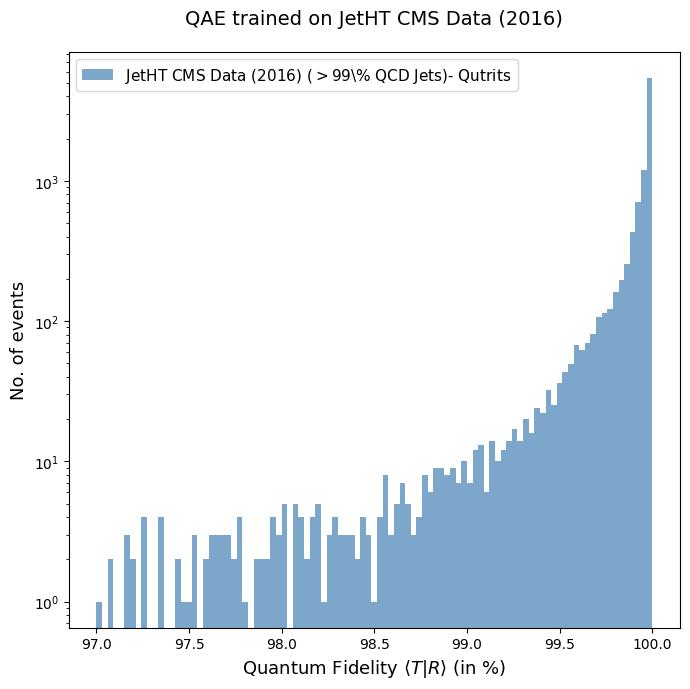

In [10]:
import matplotlib.pyplot as plt

bins = np.linspace(97, 100, 100)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)- Qutrits')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig("qae_fidelity_distribution_matched_QUTRITS.png", dpi=300, bbox_inches='tight')
plt.show()

# **Qutrit QAE inference and fidelity evaluation**

This code performs **inference on multiple datasets** using the trained qutrit Quantum Autoencoder:

- **Datasets Tested:** Background jets (`X_inf`) and signal jets (`HToBB`, `TTBar`, `WToqq`).  
- **Fidelity Computation:** For each jet, computes the fidelity from the cost function and stores it per event.  
- **Labeling:** Assigns labels (`0` for background, `1` for signal) for later analysis.  
- **Output:** Tracks per-event fidelities and prints the elapsed time for each evaluation phase.


In [ ]:
event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []
fidelidades = []
etiquetas = []

inicio = time.time()
for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

end = time.time()
tiempo_test = (end - inicio)/ 60

inicio = time.time()
for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

end = time.time()
tiempo_inf = (end - inicio)/ 60

Terminada prueba de validación
Tiempo transcurrido:  1.072627564271291
Terminada prueba con HToBB
Terminada prueba con TTBar
Terminada prueba con WToqq
Tiempo transcurrido:  2.53843222061793


# Fidelity distribution visualization

This code generates a **histogram plot of quantum fidelities** for different jet datasets after QAE inference:

- **Datasets Visualized:** Background jets (`JetHT CMS Data`), `H→bb`, `t→bqq`, and `W→qq`.  
- **Plot Style:** Background filled in blue, signals in colored step lines with different styles.  
- **Axis and Scale:** Y-axis in logarithmic scale; X-axis shows fidelity percentages.  
- **Purpose:** Provides a clear visual comparison of how well the Quantum Autoencoder reconstructs different jet types.


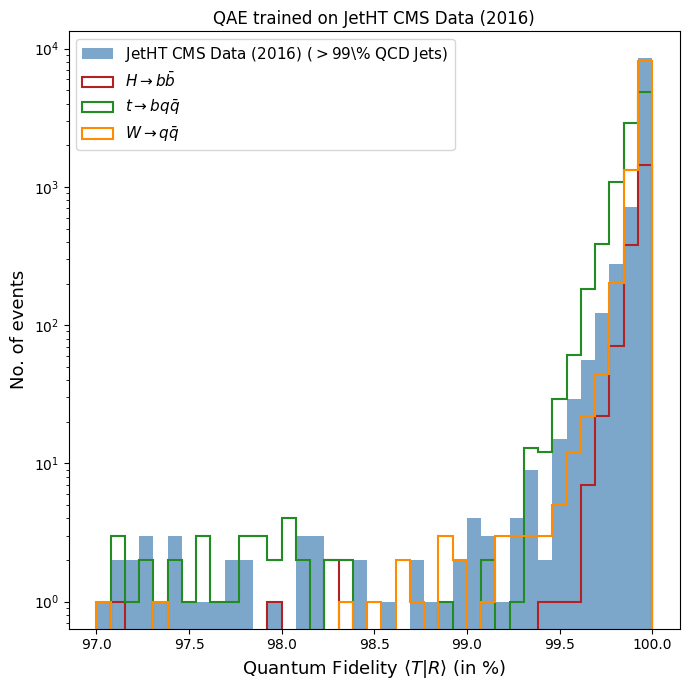

In [ ]:
plt.figure(figsize=(7, 7))


bins = np.linspace(97, 100, 40)


plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)')

plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

In [14]:
print("Avrg Fidelity Validation:")
print(np.mean(fidelidades) * 100)
print("Avrg Fidelity Test:")
print("Event Back:", np.mean(event_fidelities_back))
print("Event HToBB:", np.mean(event_fidelities_HToBB))
print("Event WToQQ:", np.mean(event_fidelities_WToQQ))
print("Event TTBar:", np.mean(event_fidelities_TTBar))



Avrg Fidelity Validation:
99.23795746536486
Avrg Fidelity Test:
Event Back: 99.51021640579826
Event HToBB: 99.07595744947629
Event WToQQ: 99.31595033984905
Event TTBar: 98.92010565362496


#  ROC curve and AUC evaluation

This code computes and visualizes the **ROC curves** for anomaly detection using quantum fidelities:

- **Data Processing:** Converts fidelities to anomaly scores (`1 - fidelity`) for background and signal jets.  
- **AUC Calculation:** Uses `roc_auc_score` to quantify separation between QCD background and signal jets (`H→bb`, `t→bqq`, `W→qq`).  
- **Visualization:** Plots ROC curves with different colors and line styles for each signal type; includes a diagonal random line (AUC=0.5) for reference.  
- **Purpose:** Evaluates the QAE's ability to discriminate signal jets from background using quantum fidelity as an anomaly score.


AUC (QCD vs H→bb): 0.7360
AUC (QCD vs t→bqq): 0.8203
AUC (QCD vs W→qq): 0.6849


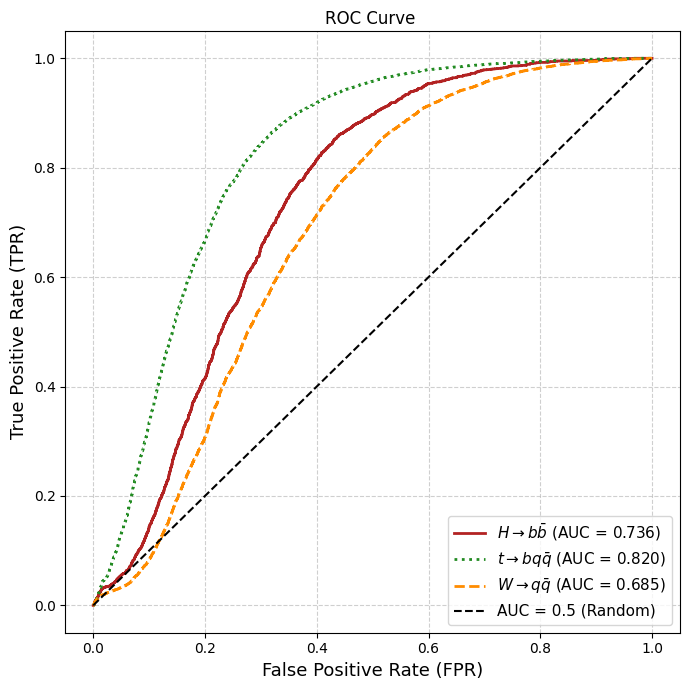

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

event_fidelities_back = np.array(event_fidelities_back) / 100
event_fidelities_HToBB = np.array(event_fidelities_HToBB) / 100
event_fidelities_TTBar = np.array(event_fidelities_TTBar) / 100
event_fidelities_WToQQ = np.array(event_fidelities_WToQQ) / 100

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calculate AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Plot ROC curves ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=2,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=2, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)
plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=2, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

# Random line (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')

# --- Customize axes and legend ---
plt.xlabel(r'False Positive Rate (FPR)', fontsize=13)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=13)
plt.title(r'ROC Curve ', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
